### Time+PSD를 input으로 넣고 Time+PSD를 Loss로 설정
이때 PSD는 welch's method로 얻음
#### X에 맞춰서 y를 scaling (X, y 각각 scaling 했을 때 학습이 잘 안됨)

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from scipy.signal import welch

import sys
sys.path.append('../../../tool_code/python_tool_code/function/') # "~~/tool_code/plot/" (상대 경로)
sys.path.append('../../../tool_code/python_tool_code/frequency_dataset_generation/')

from DataPlot import Data_Load_Plot, Result_Plot, Loss_Plot
from Scaling import time_scaling, time_inv_scaling
from FFT_func import FFT

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


Contaminated_data.shape: (10000, 4000)
Clean_data.shape: (10000, 4000)


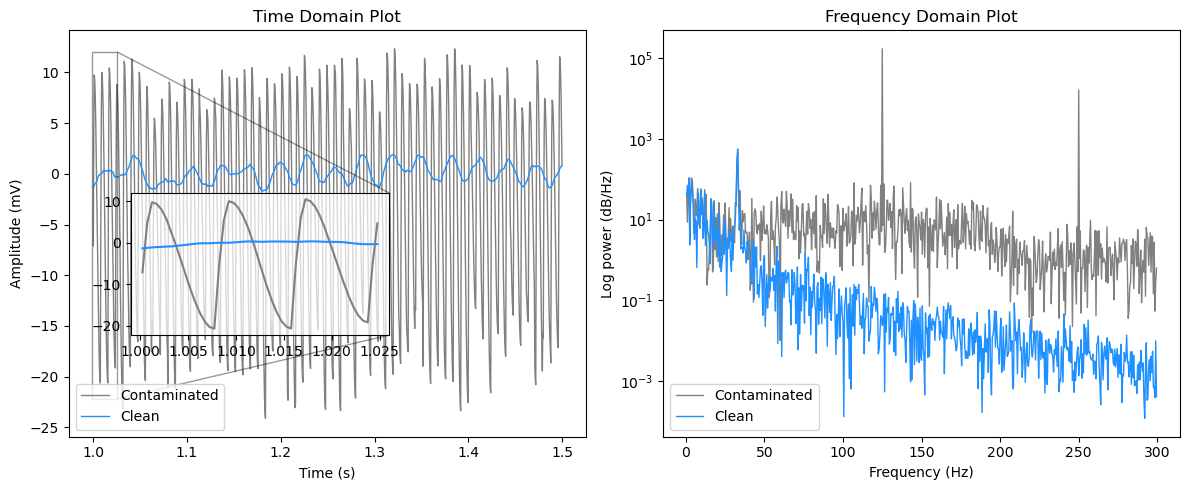

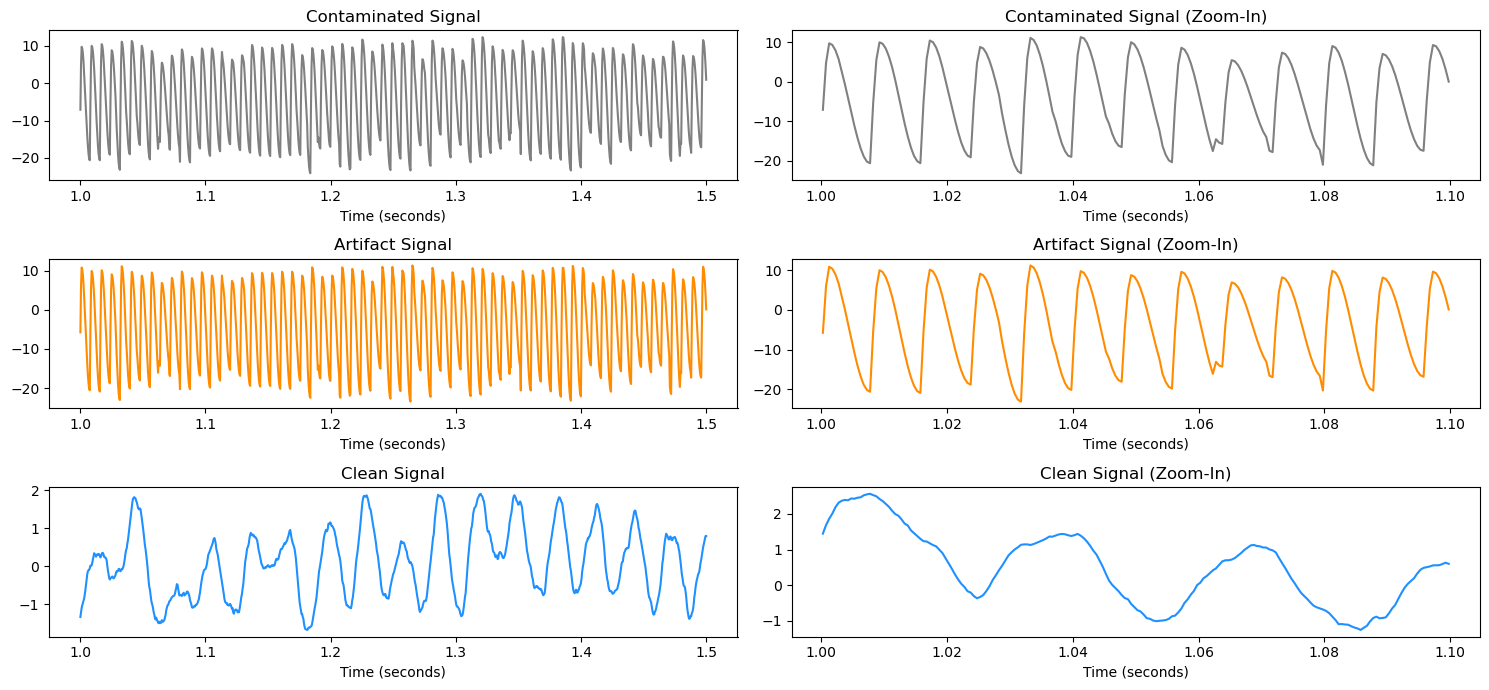

In [2]:
# 데이터 load & plot
# datapath='../../../data/synthetic_data/'
datapath = "C:/Users/stell/OneDrive/바탕 화면/paper_data/"

Contaminated_data, Clean_data, Artifact_data = Data_Load_Plot(datapath)

In [3]:
# Data Standard Scaling
X_time, y_time, scaler_x, scaler_y = time_scaling(Contaminated_data, Clean_data, standard='x')

X: (10000, 4000)
y: (10000, 4000)


In [4]:
# PSD
freqs, _, _, X_psd = FFT(X_time, fs=2000, single_sided=False)
_, _, _, y_psd = FFT(y_time, fs=2000, single_sided=False)

In [5]:
# 1 - time series Data preprocessing
X1_train, X1_test, y1_train, y1_test = train_test_split(X_time, y_time, test_size=0.2, random_state=42)

print("<Original>")
print("-----------------------------")
print(f"X1_train shape: {X1_train.shape}\ny1_train shape: {y1_train.shape}") # x : B x T, y : B x T
print("-----------------------------")
print(f"X1_test shape: {X1_test.shape}\ny1_test shape: {y1_test.shape}")
print("-----------------------------")

train_dataset1 = TensorDataset(torch.tensor(X1_train, dtype=torch.float32), torch.tensor(y1_train, dtype=torch.float32))
test_dataset1 = TensorDataset(torch.tensor(X1_test, dtype=torch.float32), torch.tensor(y1_test, dtype=torch.float32))

train_loader1 = DataLoader(dataset=train_dataset1, batch_size=32, shuffle=True)
test_loader1 = DataLoader(dataset=test_dataset1, batch_size=32, shuffle=False)

# 2 - psd Data preprocessing
X2_train, X2_test, y2_train, y2_test = train_test_split(X_psd, y_psd, test_size=0.2, random_state=42)

print("<Original>")
print("-----------------------------")
print(f"X2_train shape: {X2_train.shape}\ny2_train shape: {y2_train.shape}") # x : B x T, y : B x T
print("-----------------------------")
print(f"X2_test shape: {X2_test.shape}\ny2_test shape: {y2_test.shape}")
print("-----------------------------")

train_dataset2 = TensorDataset(torch.tensor(X2_train, dtype=torch.float32), torch.tensor(y2_train, dtype=torch.float32))
test_dataset2 = TensorDataset(torch.tensor(X2_test, dtype=torch.float32), torch.tensor(y2_test, dtype=torch.float32))

train_loader2 = DataLoader(dataset=train_dataset2, batch_size=32, shuffle=True)
test_loader2 = DataLoader(dataset=test_dataset2, batch_size=32, shuffle=False)

<Original>
-----------------------------
X1_train shape: (8000, 4000)
y1_train shape: (8000, 4000)
-----------------------------
X1_test shape: (2000, 4000)
y1_test shape: (2000, 4000)
-----------------------------
<Original>
-----------------------------
X2_train shape: (8000, 4000)
y2_train shape: (8000, 4000)
-----------------------------
X2_test shape: (2000, 4000)
y2_test shape: (2000, 4000)
-----------------------------


In [6]:
class CNN(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Conv1d(in_channels, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(256, 512, kernel_size=3, padding=1)
        self.conv5 = nn.Conv1d(512, 256, kernel_size=3, padding=1)
        self.conv6 = nn.Conv1d(256, 128, kernel_size=3, padding=1)
        self.conv7 = nn.Conv1d(128, 64, kernel_size=3, padding=1)
        self.conv8 = nn.Conv1d(64, out_channels, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        # x = self.gelu(self.conv1(x))
        # x = self.gelu(self.conv2(x))
        # x = self.gelu(self.conv3(x))
        # x = self.gelu(self.conv4(x))
        # x = self.gelu(self.conv5(x))
        # x = self.gelu(self.conv6(x))
        # x = self.gelu(self.conv7(x))
        # x = self.gelu(self.conv8(x))
        # x = self.dropout(x)
        
        # return x
    
        x = self.pool(self.gelu(self.conv1(x)))
        x = self.pool(self.gelu(self.conv2(x)))
        x = self.pool(self.gelu(self.conv3(x)))
        x = self.pool(self.gelu(self.conv4(x)))
        x = self.pool(self.gelu(self.conv5(x)))
        x = self.pool(self.gelu(self.conv6(x)))
        x = self.pool(self.gelu(self.conv7(x)))
        x = self.gelu(self.conv8(x))
        x = self.dropout(x)
        
        return x

class JointSpaceModel(nn.Module):
    def __init__(self):
        super(JointSpaceModel, self).__init__()
        self.cnn_time = CNN(in_channels=1, out_channels=64)
        self.cnn_psd = CNN(in_channels=1, out_channels=64)
        self.fc_joint = nn.Linear(128, 1)
        self.fc_recover = nn.Linear(31, 4000)
        self.fc_output = nn.Linear(1, 1)
        self.gelu = nn.GELU()

    def forward(self, time_series, psd): # time_series : B x T, psd : B x T
        time_features = self.cnn_time(time_series.unsqueeze(1)) # B x 1 x 4000 -> B x 64 x 31
        psd_features = self.cnn_psd(psd.unsqueeze(1)) # B x 1 x 4000 -> B x 64 x 31
        joint_features = torch.cat((time_features, psd_features), dim=1) # B x 128 x 31
        joint_space = self.gelu(self.fc_joint(joint_features.permute(0,2,1))) # B x 31 x 128 -> B x 31 x 1
        recovered_time_series = self.gelu(self.fc_recover(joint_space.permute(0,2,1))).squeeze() # B x 1 x 31 -> B x 1 x 4000
        return recovered_time_series
    
class JointSpaceModel_v2(nn.Module):
    def __init__(self):
        super(JointSpaceModel_v2, self).__init__()
        self.cnn_time = CNN(in_channels=1, out_channels=1)
        self.cnn_psd = CNN(in_channels=1, out_channels=1)
        self.fc_joint = nn.Linear(2, 1) 
        self.fc_output = nn.Linear(1, 1)
        self.gelu = nn.GELU()

    def forward(self, time_series, psd): # time_series : B x T, psd : B x T
        time_features = self.cnn_time(time_series.unsqueeze(1)) # B x 1 x 4000 -> B x 1 x 4000
        psd_features = self.cnn_psd(psd.unsqueeze(1)) # B x 1 x 4000 -> B x 1 x 4000
        joint_features = torch.cat((time_features, psd_features), dim=1) # B x 2 x 4000
        joint_space = self.gelu(self.fc_joint(joint_features.permute(0,2,1))) # B x 4000 x 2 -> B x 4000 x 1
        output_time_series = self.gelu(self.fc_output(joint_space)).squeeze() # B x 4000 x 1
        return output_time_series


In [7]:
model = JointSpaceModel().to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(model)

JointSpaceModel(
  (cnn_time): CNN(
    (conv1): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv2): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv3): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv4): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv5): Conv1d(512, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv6): Conv1d(256, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv7): Conv1d(128, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv8): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (gelu): GELU(approximate='none')
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (cnn_psd): CNN(
    (conv1): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv2): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv3): Conv1d(128, 256, kern

In [8]:
# 모델 학습
num_epochs = 500

loss_list = []

# Learning rate scheduler 초기화
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for (x1, y1), (x2, y2) in zip(train_loader1, train_loader2):
        x1, y1 = x1.to(device), y1.to(device)
        x2, y2 = x2.to(device), y2.to(device)
        
        optimizer.zero_grad()
        
        # 모델 예측
        y_pred = model(x1, x2)
        
        # 손실 계산
        loss = criterion(y_pred, y1)
        
        # 역전파 및 최적화
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * x1.size(0)
    
    epoch_loss = running_loss / len(train_loader1.dataset)
    loss_list.append(epoch_loss)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss}')

    # Learning rate scheduler step
    scheduler.step()

Epoch [1/500], Loss: 0.023842456812039017
Epoch [2/500], Loss: 0.0063155051097273825
Epoch [3/500], Loss: 0.006020106142386794
Epoch [4/500], Loss: 0.00587144848331809
Epoch [5/500], Loss: 0.005762006957083941
Epoch [6/500], Loss: 0.005703738665208221
Epoch [7/500], Loss: 0.0056495096758008
Epoch [8/500], Loss: 0.005616002701222897
Epoch [9/500], Loss: 0.0055915526412427426
Epoch [10/500], Loss: 0.00556888279877603
Epoch [11/500], Loss: 0.005560438895598054
Epoch [12/500], Loss: 0.005544096406549215
Epoch [13/500], Loss: 0.0055378736052662135
Epoch [14/500], Loss: 0.005533192347735166
Epoch [15/500], Loss: 0.005527155820280314
Epoch [16/500], Loss: 0.005524427253752947
Epoch [17/500], Loss: 0.005523970169946551
Epoch [18/500], Loss: 0.005522071922197938
Epoch [19/500], Loss: 0.005519804630428553
Epoch [20/500], Loss: 0.005519673822447658
Epoch [21/500], Loss: 0.00551930888928473
Epoch [22/500], Loss: 0.005519585216417908
Epoch [23/500], Loss: 0.005517134917899966
Epoch [24/500], Loss: 

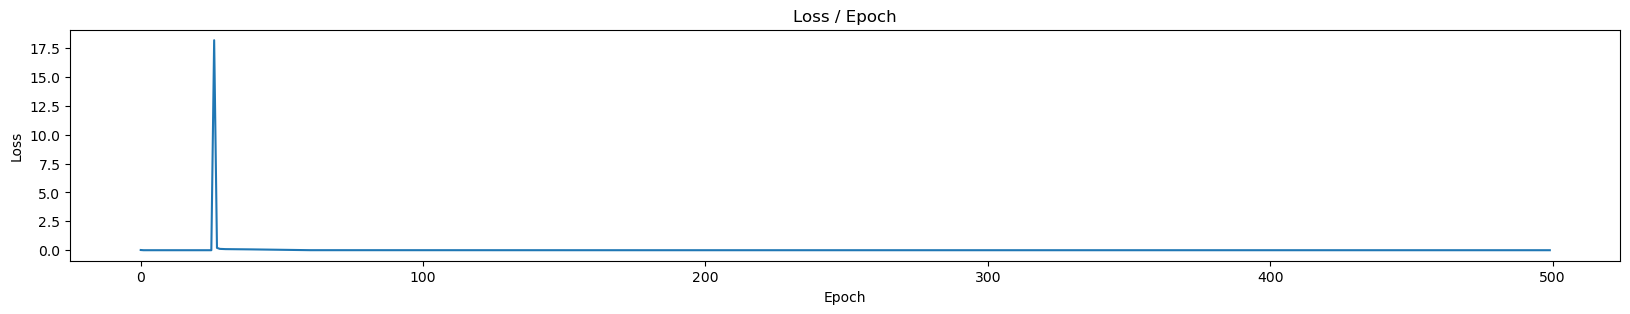

Minimal Loss: 0.005514830637723208 [25]



In [9]:
# Train Loss Plot
Loss_Plot(loss_list)

In [10]:
# 모델 평가
Contaminated = torch.tensor([])
Clean = torch.tensor([])
SACed = torch.tensor([])

model.eval()
test_loss = 0.0
with torch.no_grad():
    for (x1, y1), (x2, y2) in zip(test_loader1, test_loader2):
        x1, y1 = x1.to(device), y1.to(device)
        x2, y2 = x2.to(device), y2.to(device)
        
        # 모델 예측
        y_pred = model(x1, x2)
        
        # 손실 계산
        loss = criterion(y_pred, y1)
        
        test_loss += loss.item() * x1.size(0)

        Contaminated = torch.cat((Contaminated, x1.cpu().detach()), dim=0)
        Clean = torch.cat((Clean, y1.cpu().detach()), dim=0)
        SACed = torch.cat((SACed, y_pred.cpu().detach()), dim=0)

test_loss /= len(test_loader1.dataset)
print(f'Test Loss: {test_loss}')

Test Loss: 0.00620274605229497


torch.Size([2000, 4000])


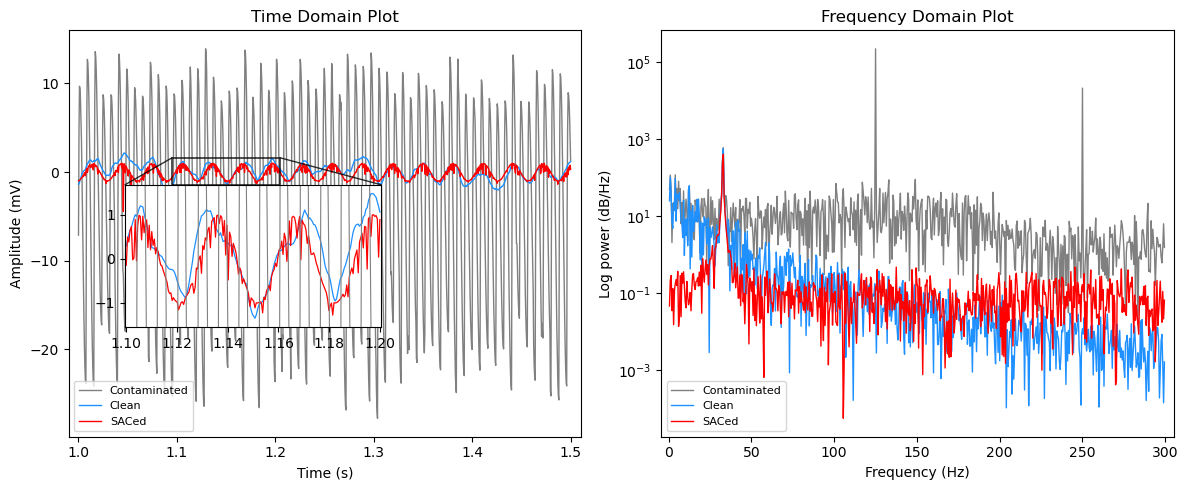

< MSE >
Time Domain MSE: 0.6176532412316135 ± 0.016262378114237183
Frequency Domain MSE: 148.74381366881695 ± 29.658446769968123
Time + Frequency MSE: 102.22751081352747 ± 13.012863760334058


In [11]:
print(Contaminated.shape)

# Inverse Scaling
Contaminated_inv_scaled, SACed_inv_scaled, Clean_inv_scaled = time_inv_scaling(Contaminated, SACed, Clean, scaler_x)

save_path = '../../../result/data_10000/CNN/'
save_title = 'CNN_IO_time+psd'

# 결과 Plot
Result_Plot(Contaminated_inv_scaled, SACed_inv_scaled, Clean_inv_scaled, save_path, save_title) # inverse scaled data를 input으로 넣음